<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/Untitled192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q

In [2]:
# --- indicator look-backs / thresholds ---
SHORT   = 5          # short channel
MEDIUM  = 20          # medium channel
VOL_MA  = 10          # volume average
BB_LEN  = 20; BB_STD  = 2
ATR_LEN = 14
RANGE_MA = 10         # for compression test
EXPANSION_MULT   = 1.50   # > = expansion
CONTRACTION_MULT = 0.75   # < = contraction

# --- New Indicator Look-backs ---
ADX_LEN = 14
RSI_LEN = 14
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9


In [3]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt
import numpy as np
api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)

In [4]:
# ================================================================
# ---- NEW: Manual Indicator Calculation Functions ----
# ================================================================

def calculate_rsi(df, length=14):
    """Calculates the Relative Strength Index (RSI) without external libraries."""
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(df, fast_len=12, slow_len=26, signal_len=9):
    """Calculates Moving Average Convergence Divergence (MACD) without external libraries."""
    ema_fast = df['Close'].ewm(span=fast_len, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=slow_len, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal_len, adjust=False).mean()
    return macd, macd_signal

def calculate_adx(df, length=14):
    """Calculates the Average Directional Index (ADX) without external libraries."""
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), df['Low'].shift(1) - df['Low'], 0)

    # Using Wilder's smoothing (similar to EMA)
    atr = df['TR'].ewm(alpha=1/length, adjust=False).mean()
    plus_di = 100 * (df['+DM'].ewm(alpha=1/length, adjust=False).mean() / atr)
    minus_di = 100 * (df['-DM'].ewm(alpha=1/length, adjust=False).mean() / atr)

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/length, adjust=False).mean()

    # Clean up temporary columns
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR', '+DM', '-DM'], axis=1, inplace=True)

    return adx, plus_di, minus_di


# ================================================================
# 2. Indicator & scoring helper (UPDATED)
# ================================================================
def score_stock(df):
    """
    df : single-symbol daily frame (already date-sorted)
    Returns df with bull_flag, bear_flag, bull_score, bear_score
    """
    # ---- moving volume mean ----
    df["vol_ma"] = df.Volume.rolling(VOL_MA).mean()

    # ---- rolling channel highs / lows ----
    df["short_hi"] = df.High.rolling(SHORT).max().shift(1)
    df["short_lo"] = df.Low.rolling(SHORT).min().shift(1)
    df["med_hi"]   = df.High.rolling(MEDIUM).max().shift(1)
    df["med_lo"]   = df.Low.rolling(MEDIUM).min().shift(1)

    # ---- Bollinger bands ----
    m  = df.Close.rolling(BB_LEN).mean()
    sd = df.Close.rolling(BB_LEN).std()
    df["bb_upper"] = m + BB_STD*sd
    df["bb_lower"] = m - BB_STD*sd

    # ---- True Range & ATR (already implemented) ----
    prev_close = df['Close'].shift(1)
    tr_high_low = df['High'] - df['Low']
    tr_high_pc  = (df['High'] - prev_close).abs()
    tr_low_pc   = (df['Low']  - prev_close).abs()
    tr = pd.concat([tr_high_low, tr_high_pc, tr_low_pc], axis=1).max(axis=1)
    df['atr'] = tr.rolling(ATR_LEN, min_periods=1).mean()

    # ---- Range compression / expansion ----
    rng     = df.High - df.Low
    rng_ma  = rng.rolling(RANGE_MA).mean()
    df["vol_exp_up"] = (
        (rng >  rng_ma * EXPANSION_MULT) &
        (rng.shift(1) < rng_ma.shift(1) * CONTRACTION_MULT) &
        (df.Close > df.Close.shift(1))
    )
    df["vol_exp_dn"] = (
        (rng >  rng_ma * EXPANSION_MULT) &
        (rng.shift(1) < rng_ma.shift(1) * CONTRACTION_MULT) &
        (df.Close < df.Close.shift(1))
    )

    # ============================================================
    # ---- NEW INDICATORS CALCULATED MANUALLY ----
    # ============================================================

    # ---- ADX (Average Directional Index) ----
    df['adx'], df['dmi_plus'], df['dmi_minus'] = calculate_adx(df.copy(), length=ADX_LEN) # Use .copy() to avoid SettingWithCopyWarning

    # ---- RSI (Relative Strength Index) ----
    df['rsi'] = calculate_rsi(df, length=RSI_LEN)

    # ---- MACD (Moving Average Convergence Divergence) ----
    df['macd'], df['macd_signal'] = calculate_macd(df, fast_len=MACD_FAST, slow_len=MACD_SLOW, signal_len=MACD_SIGNAL)


    # ============================================================
    # 3. Eight bullish / bearish tests (UPDATED)
    # ============================================================
    df["sig1_bull"] = (df.Close > df.short_hi) & (df.Volume > df.vol_ma)
    df["sig1_bear"] = (df.Close < df.short_lo) & (df.Volume > df.vol_ma)

    df["sig2_bull"] = df.Close > df.med_hi
    df["sig2_bear"] = df.Close < df.med_lo

    df["sig3_bull"] = df.Close > df.bb_upper
    df["sig3_bear"] = df.Close < df.bb_lower

    df["sig4_bull"] = df.vol_exp_up
    df["sig4_bear"] = df.vol_exp_dn

    channel_mid = (df.short_hi + df.short_lo) / 2
    df["sig5_bull"] = (df.Close > channel_mid) & (df.atr > df.atr.shift(1))
    df["sig5_bear"] = (df.Close < channel_mid) & (df.atr > df.atr.shift(1))

    # ---- New Signals ----
    df["sig6_bull"] = (df.dmi_plus > df.dmi_minus) & (df.adx > 20) & (df.adx > df.adx.shift(1))
    df["sig6_bear"] = (df.dmi_minus > df.dmi_plus) & (df.adx > 20) & (df.adx > df.adx.shift(1))

    df["sig7_bull"] = (df.rsi.shift(1) < 30) & (df.rsi > 30)
    df["sig7_bear"] = (df.rsi.shift(1) > 70) & (df.rsi < 70)

    df["sig8_bull"] = (df.macd.shift(1) < df.macd_signal.shift(1)) & (df.macd > df.macd_signal)
    df["sig8_bear"] = (df.macd.shift(1) > df.macd_signal.shift(1)) & (df.macd < df.macd_signal)

    return df

nifty_final=score_stock(nifty_data_format)

# ---- score & flags (UPDATED) ----
bull_cols = ["sig1_bull","sig2_bull","sig3_bull","sig4_bull","sig5_bull", "sig6_bull", "sig7_bull", "sig8_bull"]
bear_cols = ["sig1_bear","sig2_bear","sig3_bear","sig4_bear","sig5_bear", "sig6_bear", "sig7_bear", "sig8_bear"]

nifty_final["bull_score"] = nifty_final[bull_cols].sum(axis=1)
nifty_final["bear_score"] = nifty_final[bear_cols].sum(axis=1)

nifty_final["bull_flag"] = nifty_final.bull_score >= 2
nifty_final["bear_flag"] = nifty_final.bear_score >= 2


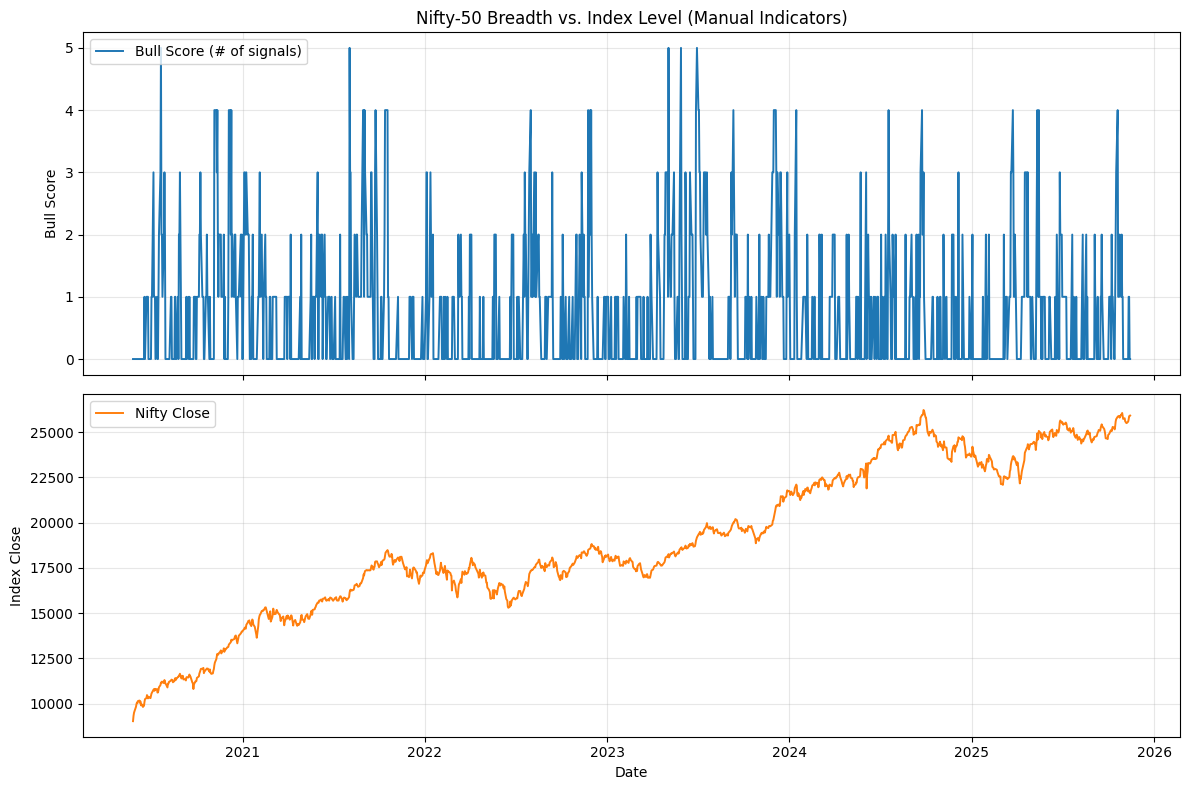

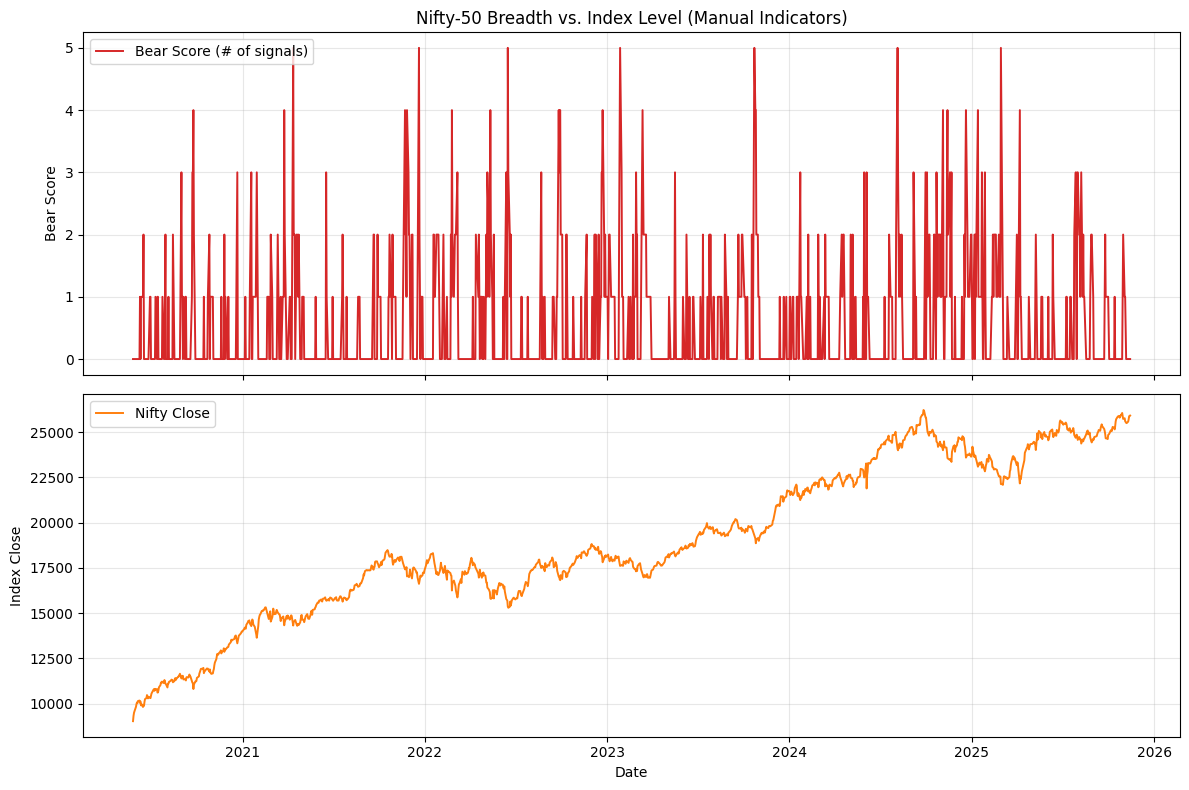

In [5]:
# --- (The rest of your plotting code remains the same) ---
import matplotlib.pyplot as plt

# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Bull score
axes[0].plot(nifty_final.index, nifty_final['bull_score'], label='Bull Score (# of signals)', linewidth=1.4)
axes[0].set_ylabel('Bull Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level (Manual Indicators)')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Bear score
axes[0].plot(nifty_final.index, nifty_final['bear_score'], label='Bear Score (# of signals)', linewidth=1.4, color='tab:red')
axes[0].set_ylabel('Bear Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level (Manual Indicators)')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()




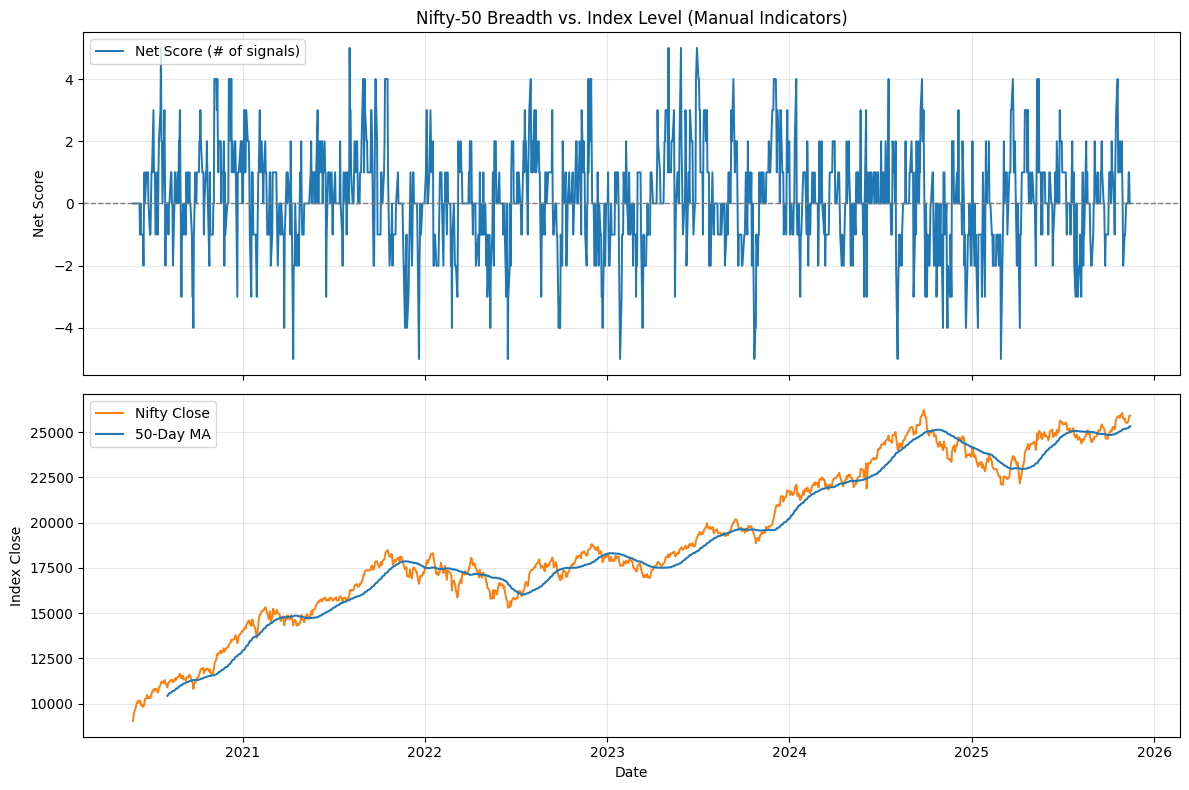

In [6]:
nifty_final['final_score']=nifty_final['bull_score']-nifty_final['bear_score']
# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Final score
axes[0].plot(nifty_final.index, nifty_final['final_score'], label='Net Score (# of signals)', linewidth=1.4)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1) # Add a zero line
axes[0].set_ylabel('Net Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level (Manual Indicators)')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].plot(nifty_final.index, nifty_final['Close'].rolling(window=50).mean(), label='50-Day MA')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

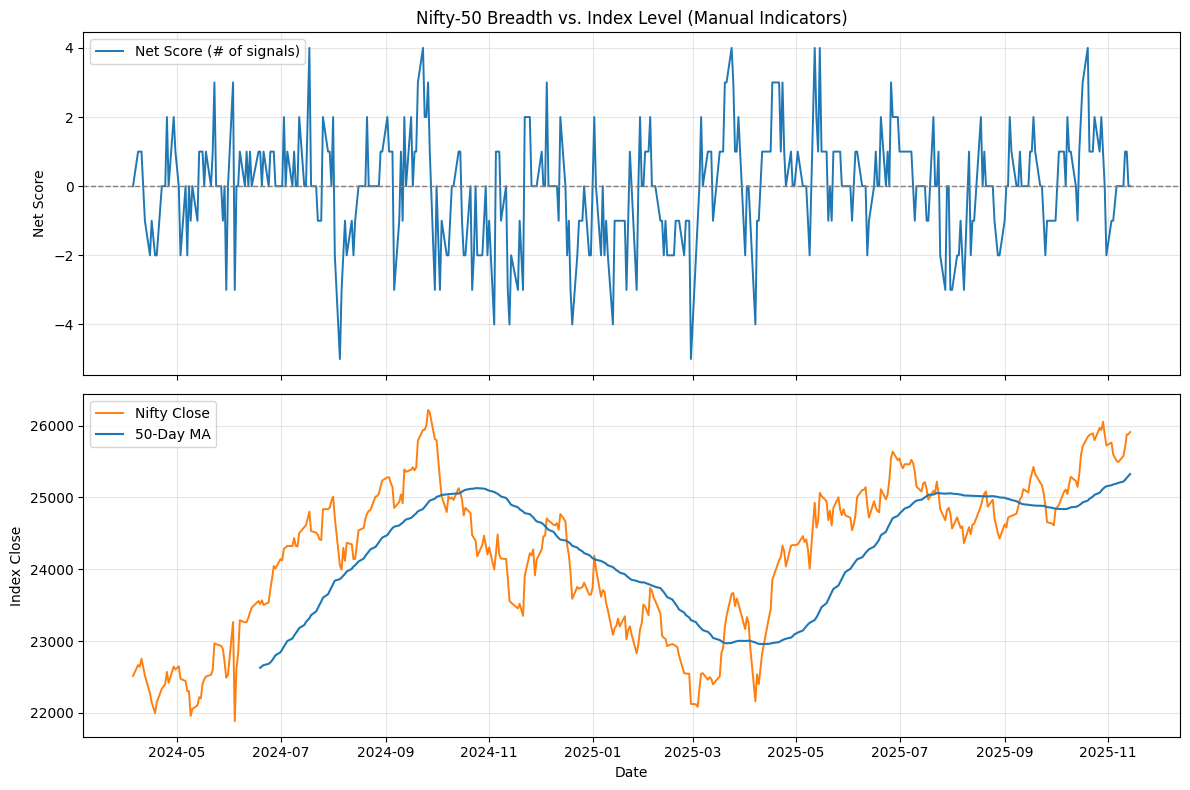

In [7]:
nifty_final=nifty_final[-400:]#['final_score']=nifty_final['bull_score']-nifty_final['bear_score']
# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Final score
axes[0].plot(nifty_final.index, nifty_final['final_score'], label='Net Score (# of signals)', linewidth=1.4)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1) # Add a zero line
axes[0].set_ylabel('Net Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level (Manual Indicators)')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].plot(nifty_final.index, nifty_final['Close'].rolling(window=50).mean(), label='50-Day MA')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()